In [5]:
# ---------------------------------------------------- 
# --- Modules  
# ---------------------------------------------------- 
using DigitalComm 
# --- External Modules
using Plots
using Printf
using FFTW
using ProgressMeter
using Statistics

In [6]:
# ---------------------------------------------------- 
# --- Core functions  
# ---------------------------------------------------- 
function  getBER(waveform,mcs,snrVect,nbSymb,nbIt)
	# ----------------------------------------------------
	# --- PSD calculation
	# ---------------------------------------------------- 
	# --- Getting frequency allocation 
	allocatedSubcarriers  = waveform.allocatedSubcarriers;
	# --- Getting number of bits 
	# First, frequency size 
	nbSubcarriers	      = length(allocatedSubcarriers);
	# Deduce number of required bits 
	nbBits			      = nbSymb * nbSubcarriers * Int(log2(mcs));
	# --- Init BER vector
	nbSNR			= length(snrVect);
	ber				= zeros(Float64,nbSNR);
	ww				= getWaveformName(waveform);
	# --- Iterative PSD calculation
	@showprogress 1 "Computing $ww ..."	for k = 1 : 1 : nbSNR
		# --- Update counters
		nbC		= 0;
		nbE		= 0;
		powSig	= 0;
		for iN = 1 : 1 : nbIt
			# --- Binary sequence
			bitSeq	      = genBitSequence(nbBits);
			# Mapping
			qamSeq		  = bitMappingQAM(mcs,bitSeq);
			# --- T/F matrix
			qamMat		  = reshape(qamSeq,nbSubcarriers,nbSymb);
			# --- Signal
			sigId		  = genSig(qamMat,waveform);
			# ---------------------------------------------------- 
			# --- Channel  
			# ---------------------------------------------------- 
			#  --- AWGN
			if iN == 1 
				# We compute the power based on generated signal 
				# We troncate the beginning and end of signal to avoid 
				# estimation biais induced by (potential) filter tails
				powSig = mean(abs2.( @views sigId[1+ end÷4 : end - end÷4]));
			end
			sigNoise,  = addNoise(sigId,snrVect[k],powSig);
			# ----------------------------------------------------
			# --- Rx Stage
			# ----------------------------------------------------
			# --- Waveform demodulator 
			qamDec	  = decodeSig(sigNoise,waveform);
			# --- Binary demapper
			bitDec	  = bitDemappingQAM(mcs,qamDec[:]);
			# --- BER measure
			nbE	 += sum(xor.(bitDec,bitSeq));
			nbC	 += length(bitSeq);
		end
		# --- BER measure
		# Adding 1e-10 to avoid log plot of zero errors
		ber[k]		= 1e-10 .+ nbE / nbC;
	end
	return ber
end


getBER (generic function with 1 method)

Computing UFOFDM ... 100%|███████████████████████████████| Time: 0:00:22
Computing FBMC ... 100%|█████████████████████████████████| Time: 0:00:01
Computing SCFDMA ... 100%|███████████████████████████████| Time: 0:00:01


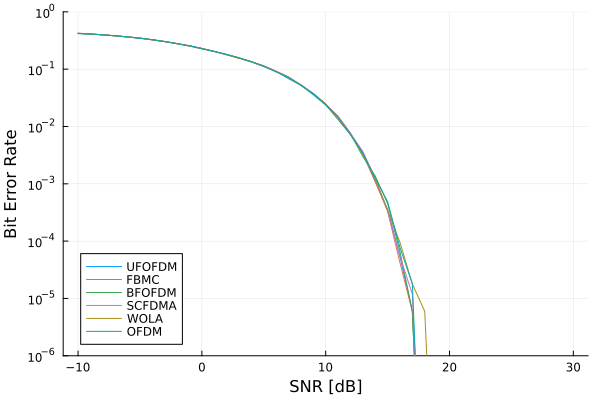

In [10]:
# ----------------------------------------------------
# --- Overall parameters
# ----------------------------------------------------
# --- Overall PHY parameters
nbIt			= 5;			  # --- Iteration number
nbSymb 			= 14;			  # --- Number of symbols (one frame)
nFFT 			= 1024;			  # --- Base FFT size
samplingFreq	= 15.36;		  # --- Frequency value (MHz)
mcs				= 16;			  # --- 16-QAM 
snrVect			= (-10:30);
# --- Frequency allocation
allocatedSubcarriers= getLTEAlloc(nFFT);

# ----------------------------------------------------
# --- Waveform contender
# ----------------------------------------------------
# --- Init OFDM structure
ofdm  = initOFDM(
                 nFFT,						        # --- nFFT                 : FFT size
                 72,						        # --- nCP                  : CP size
                 allocatedSubcarriers		        # --- allocatedSubcarriers : Subcarrier allocation
                 );
# --- Init SCFDMA structure
scfdma  = initSCFDMA(
                     nFFT,						        # --- nFFT                 : FFT size
                     72,						        # --- nCP                  : CP size
                     allocatedSubcarriers,		        # --- allocatedSubcarriers : Subcarrier allocation
                     12;								# --- sizeDFT			   : DFT preprocessing size
                     );
# --- Init UF-OFDM structure
ufofdm  = initUFOFDM(
                     nFFT,					        # --- nFFT                 : FFT size
                     73,					        # --- L                    : Filter length (same size +1 due to conv)
                     allocatedSubcarriers,	        # --- allocatedSubcarriers : Subcarrier allocation
                     applyPD=1,				        # --- applyPD              : Do predistortion at Tx stage
                     attenuation=40,		        # --- attenuation          : Filter attenuation in dB
                     );
# --- Init BF-OFDM structure
bfofdm	= initBFOFDM(
                     32,				            # --- nFBMC                : PPN size (max number of carriers)
                     64,				            # --- nOFDM                : Precoder size (OFDM sizer)
                     3,				            	# --- K                    : Overlapping factor
                     9,					            # --- GI                   : CP size of precoder
                     0.5,				            # --- δ                    : compression factor
                     allocatedSubcarriers,          # --- allocatedSubcarriers : Subcarrier allocation
                     "gaussian",	            # --- filterName           : Pulse shape name
                     BT=0.36,				        # --- BT                   : Potential BT value for Gaussian
                     filterStopBand = 110,			# --- filterStopBand       : DC stopband value
                     fS=[],				            # --- fS                   : Potential frequency coefficient for FS filter
                     nFFT= 1024,		            # --- nFFT                 : associated FFT value in Rx
                     nCP= 72,			            # --- nCP                  : extended CP size
                     );
# --- Init WOLA-OFDM structure
wola  = initWOLA(
                 nFFT,						        # --- nFFT                 : FFT size
                 72,						        # --- nCP                  : CP size
                 allocatedSubcarriers,		        # --- allocatedSubcarriers : Subcarrier allocation
                 "triangle",						# --- Window type @Tx side
                 20,								# --- Window size @Tx side
                 "triangle",						# --- Window type @Rx side
                 20,								# --- Window size @Rx side
                 );
fbmc  = initFBMC(
                 nFFT,						        # --- nFFT                 : FFT size
                 4,									# --- K					   : Overlapping factor
                 allocatedSubcarriers		        # --- allocatedSubcarriers : Subcarrier allocation
                 );

# ----------------------------------------------------
# --- Merging structures
# ----------------------------------------------------
# Create  a dictionnary to rule them all 
waveforms 	= initWaveforms(ofdm,
                            scfdma,
                            ufofdm,
                            bfofdm,
                            wola,
                            fbmc,
                            );


# ---------------------------------------------------- 
# --- BER main calculation  
# ---------------------------------------------------- 
# --- Init plot container 
plt	  = plot(reuse=false,yscale=:log10,legend=:bottomleft);
# --- Iterative PSD generation
for (name,struc) in waveforms 
    # --- Calculate PSD for the configuration 
    ber	= getBER(struc,mcs,snrVect,nbSymb,nbIt);
    # --- Plot stuff
    plot!(plt,snrVect,ber,label=name);
end

# --- Adding metata do plot curve
plot!(
    xlabel = "SNR [dB]", ylabel = "Bit Error Rate"
    , ylims = (1e-6,1)
)

